#Mounting google drive to Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
FilePath = 'my_work/new/Transfer_Learning/transfer_learning_with_fine_tuning'
%cd /content/drive/My\ Drive/$FilePath


/content/drive/My Drive/my_work/new/Transfer_Learning/transfer_learning_with_fine_tuning


##Helper function


Instead of always constructing some common funtion, we can save all of  these function as a python file and import them whenever we are need them  

In [3]:
!wget https://github.com/Henas12/Transfer-Learning/blob/main/helper_functions.py

--2024-04-05 19:04:10--  https://github.com/Henas12/Transfer-Learning/blob/main/helper_functions.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘helper_functions.py.1’

helper_functions.py     [  <=>               ] 176.84K   686KB/s    in 0.3s    

2024-04-05 19:04:11 (686 KB/s) - ‘helper_functions.py.1’ saved [181080]



In [4]:
from helper_functions import create_tensorboard_callback,unzip_data, walk_through_dir, plot_loss_curves


#101 Food Classes: Working with less data


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-08-23 14:18:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  65.7MB/s    in 2.4s    

2023-08-23 14:18:25 (65.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [8]:
unzip_data('10_food_classes_10_percent.zip')

In [9]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

#Creating data loaders (preparing the data)

In [10]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                             image_size=IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                             batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Funstional Keras API

The functional mode in Keras provides more flexibility and allows you to build complex neural network architectures.

##Model 0:Building a transfer learning model using keras Function API

In [12]:

# 1. Create base model with tf.keras.applications
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data)),
                                 # Track our model's training logs for visualization later
                                #  callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_Extract")]
                                 )

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_Extract/20240405-191116
Epoch 1/5
24/24 [==============================] - 312s 13s/step - loss: 1.8103 - accuracy: 0.4453 - val_loss: 1.2938 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 9s 344ms/step - loss: 1.0679 - accuracy: 0.7693 - val_loss: 0.8538 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 7s 283ms/step - loss: 0.7797 - accuracy: 0.8133 - val_loss: 0.6821 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 8s 312ms/step - loss: 0.6264 - accuracy: 0.8600 - val_loss: 0.6077 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 8s 277ms/step - loss: 0.5387 - accuracy: 0.8947 - val_loss: 0.5535 - val_accuracy: 0.8569


In [13]:
# for layer_number, layer in enumerate(base_model.layers):
#   print(layer_number,layer.name)

tf.keras.models.save_model(model_0,'Modl0')

In [14]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

In [ ]:
# model_0.evaluate(test_data)

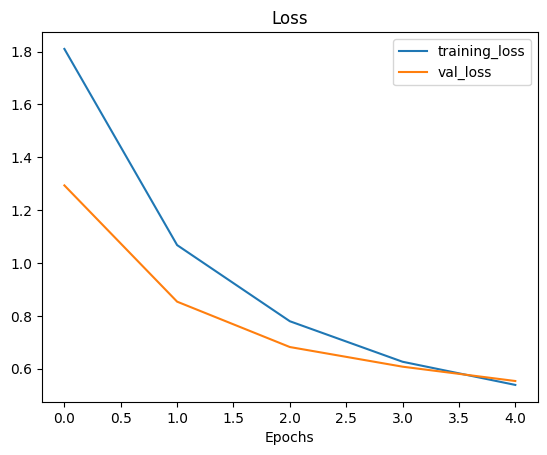

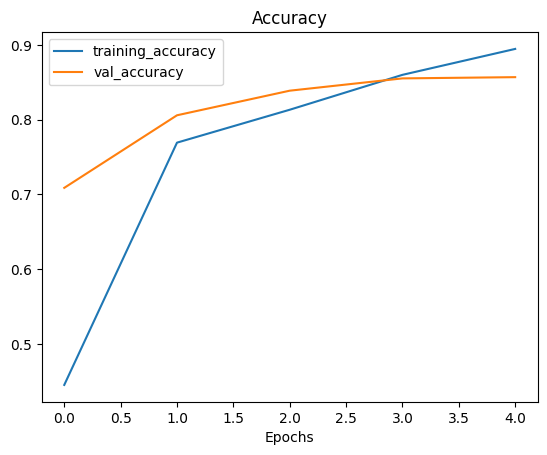

In [15]:
plot_loss_curves(history_10_percent)

In [16]:
input_shape = (1,4,4,3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f'The shape of pooled tensor is: {global_average_pooled_tensor.shape}')


The shape of pooled tensor is: (1, 3)


## Let's run several models

In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-08-26 07:22:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.128, 74.125.70.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  20.9MB/s    in 6.1s    

2023-08-26 07:22:51 (20.9 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [18]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [19]:

train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir_1_percent = '10_food_classes_1_percent/test'

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory =train_dir_1_percent,
                                                                 image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode = 'categorical'
                                                                 )


test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory =test_dir_1_percent,
                                                                 image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode = 'categorical'
                                                                 )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(.2),
    preprocessing.RandomZoom(.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomHeight(.2)

], name='data_augmentation')


## Let's visualization the data

Text(0.5, 1.0, 'Augmented ice_cream')

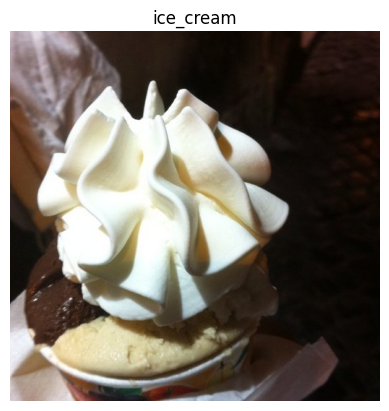

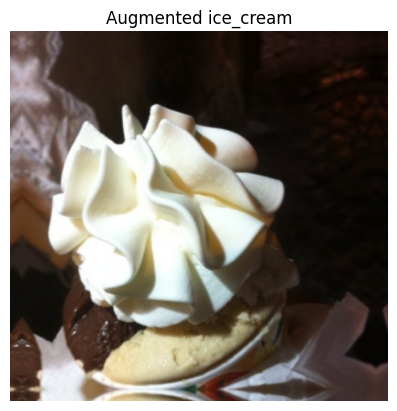

In [21]:
import matplotlib.pyplot as plt
import  matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = train_dir_1_percent + '/' +  target_class
image_path = target_dir + '/' + random.choice (os.listdir(target_dir))
image = mpimg.imread(image_path)
plt.imshow(image)
plt.title(target_class)
plt.axis('off')

#Now for the augmented random image

augmented_img = data_augmentation(tf.expand_dims(image,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis("off")
plt.title(f'Augmented {target_class}')



## Model_1 Feature etraction transfer learning on 1% of the data with augmentation

In [22]:
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape =input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)

x= layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
outputs  = layers.Dense(10, activation='softmax', name ='output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

hestory_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch =len(train_data_1_percent),
                        validation_data =test_data_1_percent,
                        validation_steps =int(.25*len(test_data_1_percent)),
                        callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                                 experiment_name='1_percent_data_Augmented')]
                        )


Saving TensorBoard log files to: transfer_learning/1_percent_data_Augmented/20240405-191934
Epoch 1/5
3/3 [==============================] - 232s 104s/step - loss: 2.3688 - accuracy: 0.0857 - val_loss: 2.2073 - val_accuracy: 0.1859
Epoch 2/5
3/3 [==============================] - 9s 3s/step - loss: 2.0627 - accuracy: 0.3429 - val_loss: 2.0867 - val_accuracy: 0.2730
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.8926 - accuracy: 0.4286 - val_loss: 1.9624 - val_accuracy: 0.3914
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.6896 - accuracy: 0.5714 - val_loss: 1.8592 - val_accuracy: 0.4638
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5727 - accuracy: 0.7429 - val_loss: 1.7695 - val_accuracy: 0.5115


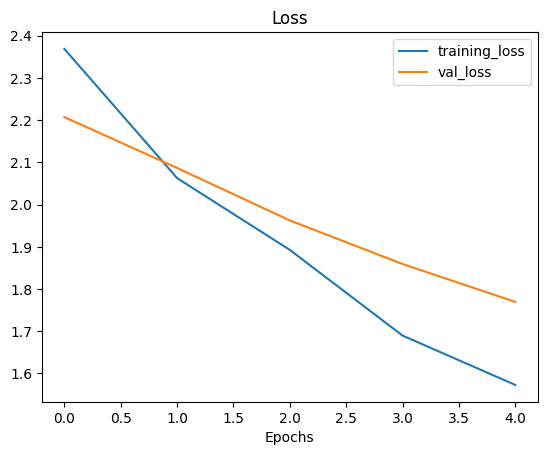

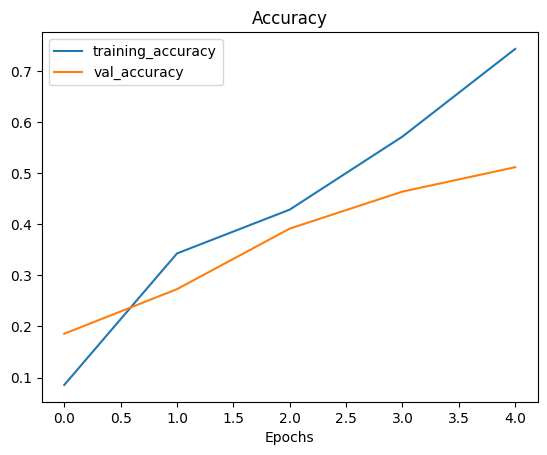

In [23]:
plot_loss_curves(hestory_1)

In [24]:
tf.keras.models.save_model(model_1, "Model_1.h2")



##Model_2: Feature extraction Transfer learning on 10 % percent of data with augmentation

In [25]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape = (224,224,3),name='inputs')
x = data_augmentation(inputs)

x= base_model(x, training =False)
x =  layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

outputs = layers.Dense(10, activation='softmax',name ='output')(x)
model_2 = tf.keras.Model(inputs,outputs)


model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



In [26]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [27]:
history_10_percent = model_2.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_Extract_with_Augmentation"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_Extract_with_Augmentation/20240405-192843
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9675 - accuracy: 0.3520
Epoch 1: val_loss improved from inf to 1.39665, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 35s 1s/step - loss: 1.9675 - accuracy: 0.3520 - val_loss: 1.3966 - val_accuracy: 0.7023
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3061 - accuracy: 0.7053
Epoch 2: val_loss improved from 1.39665 to 0.98297, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 877ms/step - loss: 1.3061 - accuracy: 0.7053 - val_loss: 0.9830 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.7773
Epoch 3: val_loss improved from 0.98297 to 0.76424, saving model to ten_percent_model_checkpoints_weights/ch

In [28]:
train_data_10_percent.as_numpy_iterator()

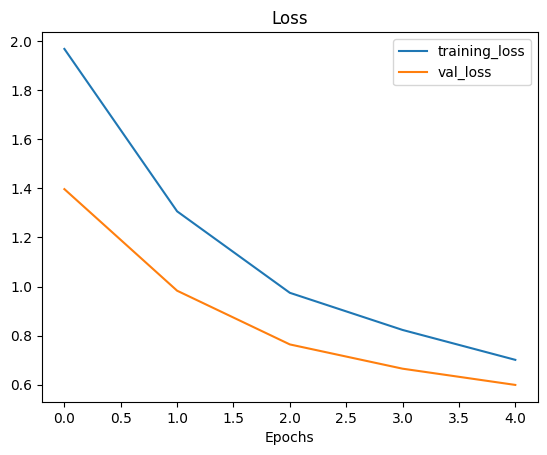

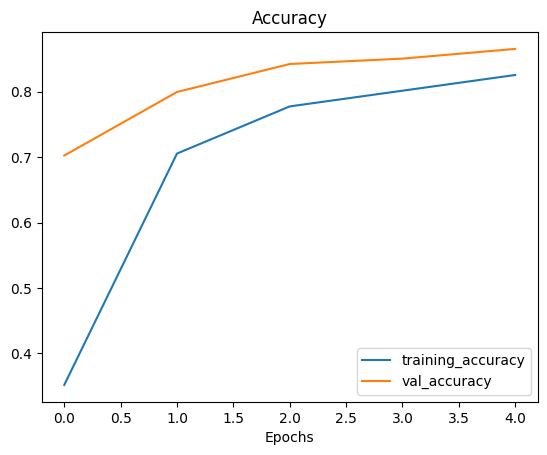

In [29]:
plot_loss_curves(history_10_percent)

In [30]:
results_of_aug_data = model_2.evaluate(test_data)

79/79 [==============================] - 367s 5s/step - loss: 0.6039 - accuracy: 0.8524


In [31]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_result = model_2.evaluate(test_data)



79/79 [==============================] - 9s 108ms/step - loss: 0.6039 - accuracy: 0.8524


In [32]:
import numpy as np
np.isclose(np.array(results_of_aug_data), np.array(loaded_weights_model_result
                                                   ))

array([ True,  True])

## Model 3:Fine-tuning existing  model on 10% of the data


During feature extraction, you only train the output layer by let the rest layers as they were. However, during Fine-tuning, unfrozen some of the layers  

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable = False


In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i,layer.name,layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:

model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), #since  our weights are already learned some pattern, we don't want to update our parameter too much
              metrics=["accuracy"])

In [ ]:
print(len(model_2.trainable_variables))
len(train_data_10_percent)

12


24

In [ ]:
initial_epochs = 5
fine_tune_epochs = initial_epochs+5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps=int(.25*len(test_data)),
                                           initial_epoch =  history_10_percent.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name='10_percent_fine_tune')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune/20230827-191611
Epoch 5/10
24/24 [==============================] - 23s 535ms/step - loss: 0.6110 - accuracy: 0.8360 - val_loss: 0.5443 - val_accuracy: 0.8421
Epoch 6/10
24/24 [==============================] - 12s 503ms/step - loss: 0.4916 - accuracy: 0.8640 - val_loss: 0.4957 - val_accuracy: 0.8470
Epoch 7/10
24/24 [==============================] - 12s 457ms/step - loss: 0.4240 - accuracy: 0.8733 - val_loss: 0.4731 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 11s 378ms/step - loss: 0.3762 - accuracy: 0.8920 - val_loss: 0.4618 - val_accuracy: 0.8618
Epoch 9/10
24/24 [==============================] - 11s 411ms/step - loss: 0.3468 - accuracy: 0.9013 - val_loss: 0.4590 - val_accuracy: 0.8553
Epoch 10/10
24/24 [==============================] - 10s 413ms/step - loss: 0.3134 - accuracy: 0.9027 - val_loss: 0.4770 - val_accuracy: 0.8438


In [ ]:
history_10_percent.epoch[-1]

4

In [ ]:
results_fine_tune = model_2.evaluate(test_data)

79/79 [==============================] - 8s 98ms/step - loss: 0.4261 - accuracy: 0.8652


In [ ]:
results_fine_tune

[0.4260919988155365, 0.8651999831199646]

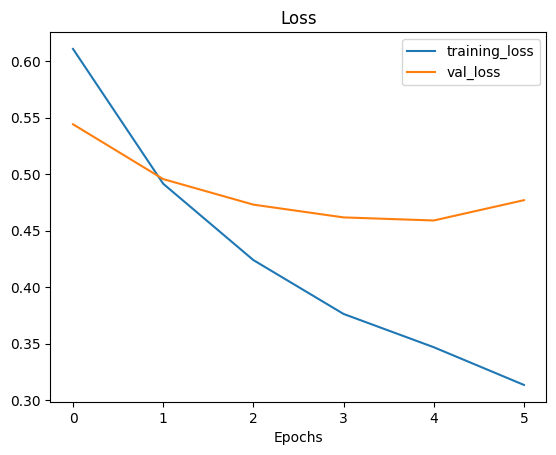

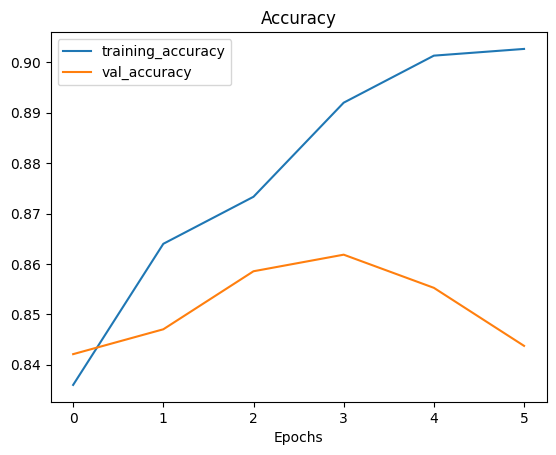

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
import matplotlib.pyplot as plt


def compare_history(original_history, new_history, initial_epochs=5):
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']
  total_acc =acc+ new_history.history['accuracy']
  total_loss = loss+new_history.history['loss']
  val_total_acc = val_acc+new_history.history['val_accuracy']
  val_total_loss = val_loss+new_history.history['val_loss']
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(val_total_acc, label='Val_accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2,1,2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(val_total_loss, label='loss_accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation loss')




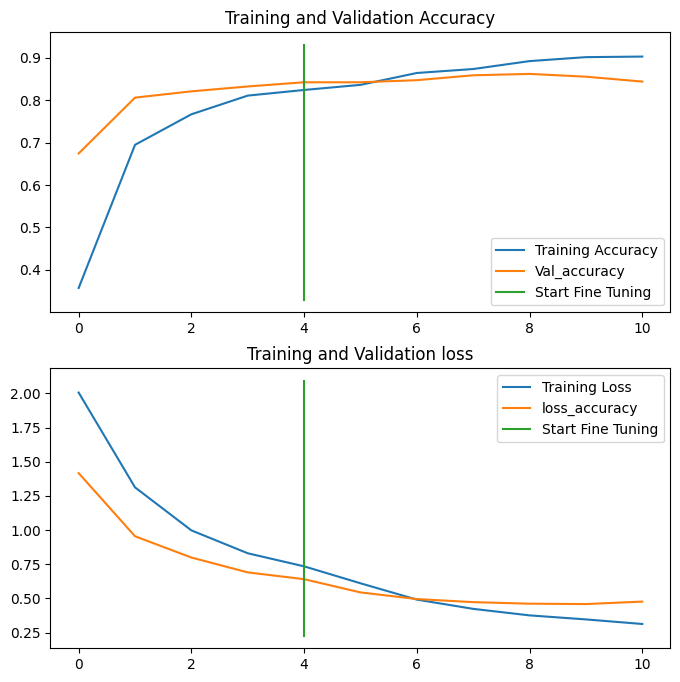

In [ ]:
compare_history(history_10_percent, history_fine_10_percent_data_aug)


In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                             image_size=IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                             batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Model 4: Fine tuning  and existing model on all of the data

In [ ]:
unzip_data('10_food_classes_all_data.zip')

In [ ]:
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [ ]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 61 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 1

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classese_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                  label_mode = 'categorical',
                                                                                  image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = 'categorical',
                                                              image_size = IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2311 files belonging to 10 classes.


In [ ]:
model_2.evaluate(test_data)

73/73 [==============================] - 12s 126ms/step - loss: 0.4331 - accuracy: 0.8620


[0.4330810308456421, 0.8619645237922668]

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), #since  our weights are already learned some pattern, we don't want to update our parameter too much
              metrics=["accuracy"])

In [ ]:
initial_epochs = 5
fine_tune_epochs = initial_epochs+5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps=int(.25*len(test_data)),
                                           initial_epoch =  history_10_percent.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name='full_10_classes_fine_tune')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20230827-195425


Epoch 5/10
24/24 [==============================] - 23s 527ms/step - loss: 0.3012 - accuracy: 0.9147 - val_loss: 0.4417 - val_accuracy: 0.8594
Epoch 6/10
24/24 [==============================] - 9s 353ms/step - loss: 0.2561 - accuracy: 0.9360 - val_loss: 0.3771 - val_accuracy: 0.8715
Epoch 7/10
24/24 [==============================] - 11s 407ms/step - loss: 0.2391 - accuracy: 0.9307 - val_loss: 0.4097 - val_accuracy: 0.8698
Epoch 8/10
24/24 [==============================] - 9s 362ms/step - loss: 0.2318 - accuracy: 0.9400 - val_loss: 0.4859 - val_accuracy: 0.8490
Epoch 9/10
24/24 [==============================] - 12s 466ms/step - loss: 0.2008 - accuracy: 0.9453 - val_loss: 0.4626 - val_accuracy: 0.8524
Epoch 10/10
24/24 [==============================] - 11s 427ms/step - loss: 0.1755 - accuracy: 0.9587 - val_loss: 0.4190 - val_accuracy: 0.8698


In [ ]:
model_2.evaluate(test_data)

73/73 [==============================] - 9s 107ms/step - loss: 0.4188 - accuracy: 0.8637


[0.41877901554107666, 0.8636953830718994]

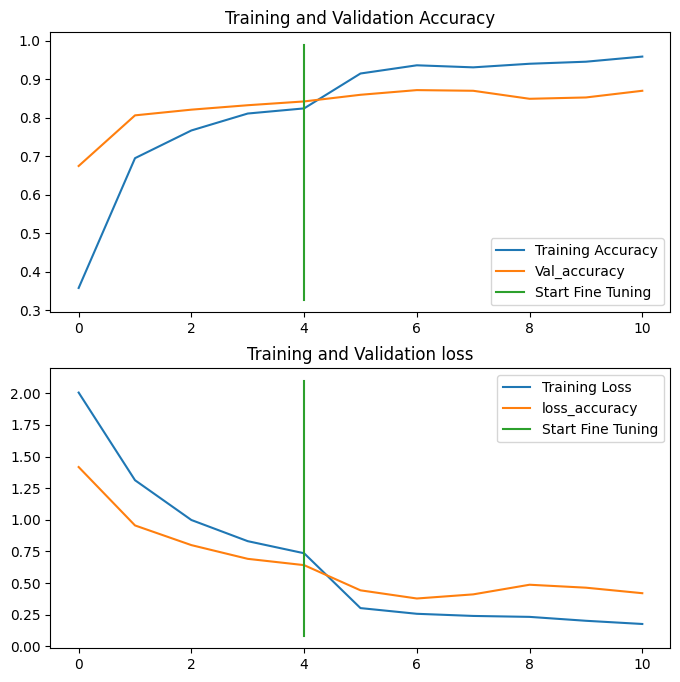

In [ ]:
compare_history(original_history=history_10_percent, new_history=history_fine_10_percent_data_aug)

## Viewing all experiments data on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning\
    --name 'Transfer Learning Experiments with 10 Food101 Classes'\
    --description 'A series of diffrent transfer learning'\
    --one_shot
